# 1. Set up/import

In [1]:
#pip install spicy
#pip install plotly
#pip install matplotlib

In [2]:
import pandas as pds
import spicy
import random
import time
import datetime
import matplotlib.pyplot as plt
import warnings
import numpy as np
import plotly.graph_objs as go
from IPython.display import HTML
from plotly.subplots import make_subplots
import plotly
import unittest


Bad key "text.kerning_factor" on line 4 in
C:\Users\giang\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# 2. Common parameter/data defining

In [3]:
#basic reroduction rate
R_0 = 2.36 #taking data from US (CRI) in 2020.

#recovery rate (taking average of 21 days from known data)
RT = 21
gamma = 1/RT
beta = R_0 * gamma

#incubation period
incubation = 9.55

#hospitalization time
#h2d: day till death while receiving treatment
h2d = 10.23
#h2rd: recovery date while receiving treatment
h2r = 12.1
#system onset to death
s2d = 16.85 

#hospitalization recovery rate
g_hc = 1/h2r
time2criticaldeath = s2d* 0.9

#reporting rate (taking china value since only that available)
rr = 0.75


In [4]:
#other required state data, using MA data from https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-16-2021.csv
N = 6912240

#active (I) = confirmed (C) - recovered (R) - deaths (D)
C0 = 669282
D0 = 17445
R0 = 52000 #this number is made up
I0 = C0 - R0 -D0
E0 = int(I0*rr)
#S + E +I +R +D = N
S0 = N - E0 - I0 - R0 -D0


#hospitalization rate, taking arbitrary number of 10.23
hr = 10.23

In [5]:
print(f'Total population is {N}')
print(f'Current Susceptible population is {S0}')
print(f'Current Exposed population is {E0}')
print(f'Current Actice cases is {I0}')
print(f'Current Recovered cases is {R0}')
print(f'Current Deaths is {D0}')

Total population is 6912240
Current Susceptible population is 5793081
Current Exposed population is 449877
Current Actice cases is 599837
Current Recovered cases is 52000
Current Deaths is 17445


# 3. Modeling

## 3.1 SEIR model (base)
N (population) = S(Susceptible) + E(Exposed) + I(Infected)+ R(Recovered)

In [6]:
#Virus simulation for 1 day (from day 0 to day 1)

prob_e = beta*I0/N # probability of an individual go from S to E
new_e = np.sum(np.random.rand(S0) < prob_e) #calculate number of new people gettting exposed
S1 = S0 - new_e #new S population after a portion getting exposed
prob_i = 1/incubation # probability of an individual go from E to I
new_i = np.sum(np.random.rand(E0) < prob_i) #calculate number of new people gettting infected
prob_r = gamma # probability of an individual go from I to R
new_r = np.sum(np.random.rand(I0) < prob_r)
E1 = E0 + new_e - new_i
I1 = I0 + new_i - new_r
R1 = R0 + new_r

print(f'Day 1 Susceptible population is {S1}')
print(f'Day 1 Exposed population is {E1}')
print(f'Day 1 Actice cases is {I1}')
print(f'Day 1 Recovered cases is {R1}')

Day 1 Susceptible population is 5736598
Day 1 Exposed population is 458924
Day 1 Actice cases is 618703
Day 1 Recovered cases is 80570


In [8]:
##Virus simulation for 60 days without any policies
S, E, I, R = np.zeros(60), np.zeros(60), np.zeros(60), np.zeros(60)

S[0], E[0], I[0], R[0] = S0, E0, I0, R0


for i in range(1, 60):
    prob_e = beta*I[i-1]/N
    new_e = np.sum(np.random.rand(int(S[i-1])) < prob_e)
    S[i] = S[i-1] - new_e
    prob_i = 1/incubation
    new_i = np.sum(np.random.rand(int(E[i-1])) < prob_i)
    prob_r = gamma
    new_r = np.sum(np.random.rand(int(I[i-1])) < prob_r)
    E[i] = E[i-1] + new_e - new_i
    I[i] = I[i-1] + new_i -new_r
    R[i] = R[i-1] + new_r
    
#display(S, E, I, R)

In [9]:
#including social_distancing factor (sd) where 0 = no social distance and 1 = locked down (no infection)
#sd [0,1]

def SEIR_simulation(S0, E0, I0, R0, period=60, sd=0):
    S, E, I, R = np.zeros(period), np.zeros(period), np.zeros(period), np.zeros(period)
    
    S[0], E[0], I[0], R[0] = S0, E0, I0, R0
    
    for i in range(1, period):
        prob_e = beta*I[i-1]*(1-sd)/N #add in social distancing factor
        new_e = np.sum(np.random.rand(int(S[i-1])) < prob_e)
        S[i] = S[i-1] - new_e
        prob_i = 1/incubation
        new_i = np.sum(np.random.rand(int(E[i-1])) < prob_i)
        prob_r = gamma
        new_r = np.sum(np.random.rand(int(I[i-1])) < prob_r)
        E[i] = E[i-1] + new_e - new_i
        I[i] = I[i-1] + new_i -new_r
        R[i] = R[i-1] + new_r
    return S, E, I, R

<function matplotlib.pyplot.show(*args, **kw)>

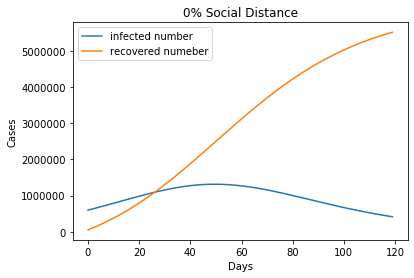

In [10]:
#try simulate for 4 months with no social distancing
S, E, I, R = SEIR_simulation(S0, E0, I0, R0, 120, 0)
plt.plot(I, label="infected number")
plt.plot(R, label="recovered numeber")
plt.title('0% Social Distance')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

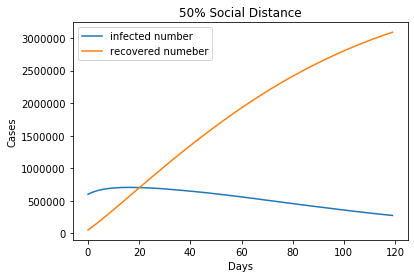

In [11]:
#try simulate for 4 months with 50% social distancing
S, E, I, R = SEIR_simulation(S0, E0, I0, R0, 120, 0.5)
plt.plot(I, label="infected number")
plt.plot(R, label="recovered numeber")
plt.title('50% Social Distance')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show

# 3.2 Assuming we make people use mask with efficacy of 30%

In [12]:
#Assume mask wil reduce the number of virus reproduction number, thus lower R and beta number.
R_1 = R_0*0.7
beta_1 = R_1 *gamma
#display(R_1, beta_1, R_0, beta)

In [13]:
def SEIR_simulation_with_mask(S0, E0, I0, R0, period=60, sd=0):
    S, E, I, R = np.zeros(period), np.zeros(period), np.zeros(period), np.zeros(period)
    
    S[0], E[0], I[0], R[0] = S0, E0, I0, R0
    
    for i in range(1, period):
        prob_e = beta_1*I[i-1]*(1-sd)/N #add in social distancing factor
        new_e = np.sum(np.random.rand(int(S[i-1])) < prob_e)
        S[i] = S[i-1] - new_e
        prob_i = 1/incubation
        new_i = np.sum(np.random.rand(int(E[i-1])) < prob_i)
        prob_r = gamma
        new_r = np.sum(np.random.rand(int(I[i-1])) < prob_r)
        E[i] = E[i-1] + new_e - new_i
        I[i] = I[i-1] + new_i -new_r
        R[i] = R[i-1] + new_r
    return S, E, I, R

<function matplotlib.pyplot.show(*args, **kw)>

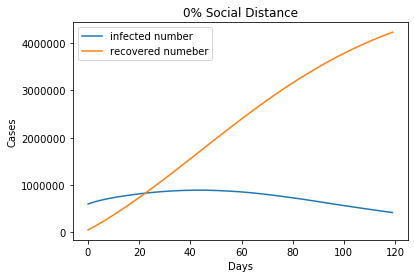

In [14]:
S, E, I, R = SEIR_simulation_with_mask(S0, E0, I0, R0, 120,0)
plt.plot(I, label="infected number")
plt.plot(R, label="recovered numeber")
plt.title('0% Social Distance')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

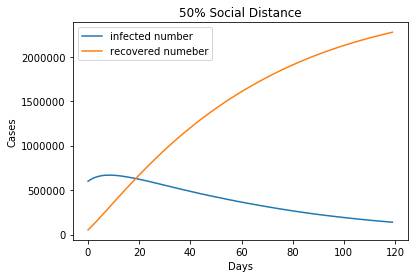

In [15]:
S, E, I, R = SEIR_simulation_with_mask(S0, E0, I0, R0, 120, 0.5)
plt.plot(I, label="infected number")
plt.plot(R, label="recovered numeber")
plt.title('50% Social Distance')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show

# 3.3 SEIR + mask + hospitalization + vaccination

Now we build a SEIR + improvement model to consider three policy factors together: social distancing, hospitalization capacity increase and vaccine injection

In [16]:
CR = 0.05 #chance that patient receive a critical illness from virus
CDR = 1/time2criticaldeath #critical death rate for non-hospitalized patients
CDR_h = 35775/832033 #critical death rate for hospitalized patients (from empirical data)
MR = 0.01  #mortality rate

#recovery rate for critically ill patient without hospitalization, mild patient without hospitalization, and critical patient with hospitalization
gamma_m = gamma
hospital_rate = 0.9
gamma_c = 0.03
gamma_c, gamma_m, g_hc

(0.03, 0.047619047619047616, 0.08264462809917356)

In [17]:
#asssuming 25% of population is vaccinated -> vaccine_p = 0.25
def SEIRHV_simulation_with_masks(S0, E0, I0, R0, D0, period=90, sd=0, h_capacity=0, vaccine_date=60, vaccine_p = 0.25):
    
    S = np.zeros(period)
    E = np.zeros(period)
    I_c = np.zeros(period)
    I_m = np.zeros(period)
    H = np.zeros(period) #hospitalization
    R = np.zeros(period)
    D = np.zeros(period)
    V = np.zeros(period) #vaacine
    
    capacity = 15000 #https://www.mass.gov/doc/command-center-hospital-capacity-charts/download
    H0 = 0 #hospitalized number
    S0 = N - E0 - I0 - R0 - D0 - H0 # S+E+I+H+R+D=N

    #simulate all critical ill patient ratios at one time
    CR_all = np.random.normal(CR, 0.001, period)

    S[0] = S0
    E[0] = E0
    I_c[0] = np.sum(np.random.rand(I0) < CR_all[0]) 
    I_m[0] = I0 - I_c[0] 
    H[0] = H0
    R[0] = R0
    D[0] = D0

    rho = 2 #sensitivity factor for controling the hospital factor on different recovery rate  
    
    for i in range(1, period):
        prob_e = beta_1*(I_c[i-1]+I_m[i-1])*(1-sd)/N
        new_e = np.sum(np.random.rand(int(S[i-1])) < prob_e)
        S[i] = S[i-1] - new_e
        #after vaccine injection: affect expose rate
        if i == vaccine_date:
            S[i] = (1-vaccine_p) * S[i-1]
            V[i] = vaccine_p * S[i-1]
        prob_i = 1/incubation
        new_i = np.sum(np.random.rand(int(E[i-1])) < prob_i)
        E[i] = E[i-1] + new_e - new_i
        
        #divide two types of patients
        new_i_c = np.sum(np.random.rand(new_i) < CR_all[i]) #critical patient
        new_i_m = new_i - new_i_c #mild patient
        
        new_d_hc = np.sum(np.random.rand(max(int(H[i-int(h2d)]),0)) < CDR_h) if i>=int(h2d) else 0 #hospitalized critical death
        new_d_c = np.sum(np.random.rand(max(int(I_c[i-int(s2d)]),0)) < CDR*(1-h_capacity))  if i>=int(s2d) else 0 #non-hospitalized critical death 
        new_d_m = np.sum(np.random.rand(max(int(I_m[i-int(s2d)]),0)) < MR*(1-h_capacity))  if i>=int(s2d) else 0 #non-hospitalized mild death

        new_r_hc = np.sum(np.random.rand(max(int(H[i-int(h2r)]),0)) < g_hc*(1+h_capacity)) if i>=int(h2r) else 0  #hospitalized critical recovery
        new_r_c = np.sum(np.random.rand(max(int(I_c[i-int(RT)]),0)) < gamma_c*(1+rho*h_capacity)) if i>=int(RT) else 0  #non-hospitalized critical recovery
        new_r_m = np.sum(np.random.rand(max(int(I_m[i-int(RT)]),0)) < gamma_m*(1+rho*h_capacity)) if i>=int(RT) else 0  #non-hospitalized mild recovery
        
        D[i] = D[i-1] + new_d_hc + new_d_c + new_d_m

        #check if hospital exceeding capacity
        new_h = np.sum(np.random.rand(max(int(I_c[i-1]),0)) < hospital_rate) if H[i-1]<capacity else 0  
                
        I_m[i] = max(I_m[i-1] + new_i_m - new_r_m - new_d_m, 0)
        I_c[i] = max(I_c[i-1] + new_i_c - new_h - new_r_c - new_d_c, 0)
        H[i] = max(H[i-1] + new_h - new_d_hc - new_r_hc, 0)
        R[i] = R[i-1] + new_r_hc + new_r_c + new_r_m
    
    
    I = I_c + I_m    
    return S, E, I, H, R, D

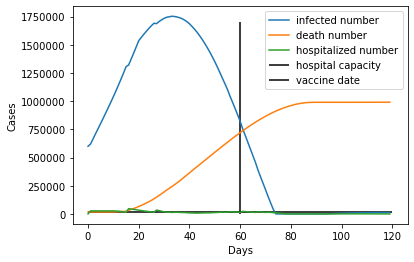

In [18]:
S, E, I, H, R, D = SEIRHV_simulation_with_masks(S0, E0, I0, R0, D0, 120, 0, 0, 60, 0.25)
plt.plot(I, label="infected number")
plt.plot(D, label="death number")
plt.plot(H, label="hospitalized number")
plt.hlines(15000, 0,120, label='hospital capacity')
plt.vlines(60, 0, 1700000, label='vaccine date')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show()

# 4. Compare 2 virus simulation

# 4.1 SARS-CoV-2 (Covid-19)

In [19]:
print("initial state:", S0, E0, I0, R0, D0)
print("parameter:", prob_e, prob_i, CDR, CDR_h, MR, gamma, gamma_c, g_hc, hospital_rate, CR)

initial state: 5793081 449877 599837 52000 17445
parameter: 0.020839520838947943 0.10471204188481674 0.06594131223211341 0.04299709266339196 0.01 0.047619047619047616 0.03 0.08264462809917356 0.9 0.05


In [20]:
sd = [0, 0.25, 0.5, 0.75]
fig = make_subplots(rows=1, cols=4, subplot_titles=("0% social distance","25% social distance","50% social distance","75% social distance"), shared_yaxes=True)
for i in range(len(sd)):
  S, E, I, H, R, D = SEIRHV_simulation_with_masks(S0, E0, I0, R0, D0, 120, sd[i], 0, 0, 0)
  if i == 0:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1',line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2',line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3',line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4',line=dict(color='Orange')), row=1, col=i+1)
  else:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1', showlegend=False,line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2', showlegend=False,line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3', showlegend=False,line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4', showlegend=False,line=dict(color='Orange')), row=1, col=i+1)
fig.update_layout(title = 'Covid_social_distancing', xaxis_title="Days",yaxis_title="Cases")
plotly.offline.plot(fig, filename='Covid_social_distancing.html')

'Covid_social_distancing.html'

In [21]:

h_capacity = [0, 0.25, 0.5, 0.75]
fig = make_subplots(rows=1, cols=4, subplot_titles=("0% extra hospitalization capacity","25% extra hospitalization capacity","50% extra hospitalization capacity","75% extra hospitalization capacity"), shared_yaxes=True)
for i in range(len(h_capacity)):
  S, E, I, H, R, D = SEIRHV_simulation_with_masks(S0, E0, I0, R0, D0, 120, 0, h_capacity[i], 0, 0)
  if i == 0:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1',line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2',line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3',line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4',line=dict(color='Orange')), row=1, col=i+1)
  else:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1', showlegend=False,line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2', showlegend=False,line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3', showlegend=False,line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4', showlegend=False,line=dict(color='Orange')), row=1, col=i+1)
fig.update_layout(title = 'Covid_hospitalization', xaxis_title="Days",yaxis_title="Cases")
plotly.offline.plot(fig, filename='Covid_hospitalization.html')

'Covid_hospitalization.html'

In [22]:
dates = [30, 60, 90]
fig = make_subplots(rows=1, cols=3, subplot_titles=("vaccine at day 30","vaccine at day 60","vaccine at day 90"), shared_yaxes=True)
for i in range(len(dates)):
  S, E, I, H, R, D = SEIRHV_simulation_with_masks(S0, E0, I0, R0, D0, 120, 0, 0, dates[i], 0.5)
  if i == 0:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1',line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2',line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3',line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4',line=dict(color='Orange')), row=1, col=i+1)
    fig.add_shape(go.layout.Shape(type="line",
                                        yref="y",
                                        xref="x",
                                        x0=dates[i],
                                        y0=0,
                                        x1=dates[i],
                                        y1=max(I+D+R),
                                        #line=dict(color="RoyalBlue", width=3),),
                                        line=dict(color='Grey', width=3),),row=1,col=i+1)
    
  else:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1', showlegend=False,line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2', showlegend=False,line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3', showlegend=False,line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4', showlegend=False,line=dict(color='Orange')), row=1, col=i+1)
    fig.add_shape(go.layout.Shape(type="line",
                                        yref="y",
                                        xref="x",
                                        x0=dates[i],
                                        y0=0,
                                        x1=dates[i],
                                        y1=max(I+D+R),
                                        #line=dict(color="RoyalBlue", width=3),),
                                        line=dict(color='Grey', width=3),),row=1,col=i+1)
    
fig.update_layout(title = 'Covid_Vaccination', xaxis_title="Days",yaxis_title="Cases")
plotly.offline.plot(fig, filename='Covid_Vaccination.html')

'Covid_Vaccination.html'

# 4.2 2009 Flu (H1N1)
refer to data in this page: https://www.researchgate.net/publication/40446592_Estimated_epidemiologic_parameters_and_morbidity_associated_with_pandemic_H1N1_influenza

In [23]:
#setting new parameter
#to keep comparision simple I will use the same population dataset
incubation2 = 4.3
RT2 = 7
R_2 = 1.31
beta_2 = R_2*1/RT2
CDR2, CDR2_h, MR2 = 0.03, 0.025, 0.002
gamma2, gamma2_c, gamma2_hc = 0.05, 0.07, 0.1
CR2 = 0.02


In [24]:
def SEIRHV_simulation2_with_masks(S0, E0, I0, R0, D0, period=90, sd=0, h_capacity=0, vaccine_date=60, vaccine_p = 0.25):
    
    S = np.zeros(period)
    E = np.zeros(period)
    I_c = np.zeros(period)
    I_m = np.zeros(period)
    H = np.zeros(period) #hospitalization
    R = np.zeros(period)
    D = np.zeros(period)
    V = np.zeros(period) #vaacine
    
    capacity = 15000 #https://www.mass.gov/doc/command-center-hospital-capacity-charts/download
    H0 = 0 #hospitalized number
    S0 = N - E0 - I0 - R0 - D0 - H0 # S+E+I+H+R+D=N

    #simulate all critical ill patient ratios at one time
    CR_all = np.random.normal(CR2, 0.001, period)

    S[0] = S0
    E[0] = E0
    I_c[0] = np.sum(np.random.rand(I0) < CR_all[0]) 
    I_m[0] = I0 - I_c[0] 
    H[0] = H0
    R[0] = R0
    D[0] = D0

    rho = 2 #sensitivity factor for controling the hospital factor on different recovery rate  
    
    for i in range(1, period):
        prob_e = beta_2*(I_c[i-1]+I_m[i-1])*(1-sd)/N
        new_e = np.sum(np.random.rand(int(S[i-1])) < prob_e)
        S[i] = S[i-1] - new_e
        #after vaccine injection: affect expose rate
        if i == vaccine_date:
            S[i] = (1-vaccine_p) * S[i-1]
            V[i] = vaccine_p * S[i-1]
        prob_i = 1/incubation2
        new_i = np.sum(np.random.rand(int(E[i-1])) < prob_i)
        E[i] = E[i-1] + new_e - new_i
        
        #divide two types of patients
        new_i_c = np.sum(np.random.rand(new_i) < CR_all[i]) #critical patient
        new_i_m = new_i - new_i_c #mild patient
        
        new_d_hc = np.sum(np.random.rand(max(int(H[i-int(h2d)]),0)) < CDR2_h) if i>=int(h2d) else 0 #hospitalized critical death
        new_d_c = np.sum(np.random.rand(max(int(I_c[i-int(s2d)]),0)) < CDR2*(1-h_capacity))  if i>=int(s2d) else 0 #non-hospitalized critical death 
        new_d_m = np.sum(np.random.rand(max(int(I_m[i-int(s2d)]),0)) < MR2*(1-h_capacity))  if i>=int(s2d) else 0 #non-hospitalized mild death

        new_r_hc = np.sum(np.random.rand(max(int(H[i-int(h2r)]),0)) < gamma2_hc*(1+h_capacity)) if i>=int(h2r) else 0  #hospitalized critical recovery
        new_r_c = np.sum(np.random.rand(max(int(I_c[i-int(RT)]),0)) < gamma2_c*(1+rho*h_capacity)) if i>=int(RT) else 0  #non-hospitalized critical recovery
        new_r_m = np.sum(np.random.rand(max(int(I_m[i-int(RT)]),0)) < gamma2*(1+rho*h_capacity)) if i>=int(RT) else 0  #non-hospitalized mild recovery
        
        D[i] = D[i-1] + new_d_hc + new_d_c + new_d_m

        #check if hospital exceeding capacity
        new_h = np.sum(np.random.rand(max(int(I_c[i-1]),0)) < hospital_rate) if H[i-1]<capacity else 0  
                
        I_m[i] = max(I_m[i-1] + new_i_m - new_r_m - new_d_m, 0)
        I_c[i] = max(I_c[i-1] + new_i_c - new_h - new_r_c - new_d_c, 0)
        H[i] = max(H[i-1] + new_h - new_d_hc - new_r_hc, 0)
        R[i] = R[i-1] + new_r_hc + new_r_c + new_r_m
    
    
    I = I_c + I_m    
    return S, E, I, H, R, D

In [25]:
sd = [0, 0.25, 0.5, 0.75]
fig = make_subplots(rows=1, cols=4, subplot_titles=("0% social distance","25% social distance","50% social distance","75% social distance"), shared_yaxes=True)
for i in range(len(sd)):
  S, E, I, H, R, D = SEIRHV_simulation2_with_masks(S0, E0, I0, R0, D0, 120, sd[i], 0, 0, 0)
  if i == 0:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1',line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2',line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3',line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4',line=dict(color='Orange')), row=1, col=i+1)
  else:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1', showlegend=False,line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2', showlegend=False,line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3', showlegend=False,line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4', showlegend=False,line=dict(color='Orange')), row=1, col=i+1)
fig.update_layout(title = 'H1N1_social_distancing', xaxis_title="Days",yaxis_title="Cases")
plotly.offline.plot(fig, filename='H1N1_social_distancing.html')

'H1N1_social_distancing.html'

In [26]:
h_capacity = [0, 0.25, 0.5, 0.75]
fig = make_subplots(rows=1, cols=4, subplot_titles=("0% extra hospitalization capacity","25% extra hospitalization capacity","50% extra hospitalization capacity","75% extra hospitalization capacity"), shared_yaxes=True)
for i in range(len(h_capacity)):
  S, E, I, H, R, D = SEIRHV_simulation2_with_masks(S0, E0, I0, R0, D0, 120, 0, h_capacity[i], 0, 0)
  if i == 0:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1',line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2',line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3',line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4',line=dict(color='Orange')), row=1, col=i+1)
  else:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1', showlegend=False,line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2', showlegend=False,line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3', showlegend=False,line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4', showlegend=False,line=dict(color='Orange')), row=1, col=i+1)
fig.update_layout(title = 'H1N1_hospitalization', xaxis_title="Days",yaxis_title="Cases")
plotly.offline.plot(fig, filename='H1N1_hospitalization.html')

'H1N1_hospitalization.html'

In [27]:
dates = [30, 60, 90]
fig = make_subplots(rows=1, cols=3, subplot_titles=("vaccine at day 30","vaccine at day 60","vaccine at day 90"), shared_yaxes=True)
for i in range(len(dates)):
  S, E, I, H, R, D = SEIRHV_simulation2_with_masks(S0, E0, I0, R0, D0, 120, 0, 0, dates[i], 0.5)
  if i == 0:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1',line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2',line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3',line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4',line=dict(color='Orange')), row=1, col=i+1)
    fig.add_shape(go.layout.Shape(type="line",
                                        yref="y",
                                        xref="x",
                                        x0=dates[i],
                                        y0=0,
                                        x1=dates[i],
                                        y1=max(I+D+R),
                                        #line=dict(color="RoyalBlue", width=3),),
                                        line=dict(color='Grey', width=3),),row=1,col=i+1)
    
  else:
    fig.add_trace(go.Scatter(x=np.arange(120), y=I, name='Infectious', legendgroup='1', showlegend=False,line=dict(color='Red')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=D, name='Death', legendgroup='2', showlegend=False,line=dict(color='Blue')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=R, name='Recovered', legendgroup='3', showlegend=False,line=dict(color='Green')), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(120), y=H, name='Hospitalized', legendgroup='4', showlegend=False,line=dict(color='Orange')), row=1, col=i+1)
    fig.add_shape(go.layout.Shape(type="line",
                                        yref="y",
                                        xref="x",
                                        x0=dates[i],
                                        y0=0,
                                        x1=dates[i],
                                        y1=max(I+D+R),
                                        #line=dict(color="RoyalBlue", width=3),),
                                        line=dict(color='Grey', width=3),),row=1,col=i+1)
    
fig.update_layout(title = 'H1N1_Vaccination', xaxis_title="Days",yaxis_title="Cases")
plotly.offline.plot(fig, filename='H1N1_Vaccination.html')

'H1N1_Vaccination.html'

# 5. Unit Test

In [28]:
#Unit Test
class TestStringMethods(unittest.TestCase):

    def test_SEIR_simulation(self):
        S, E, I, R = SEIR_simulation(S0, E0, I0, R0, 1, 0)
        self.assertEqual((S,E,I,R),(5793081,449877, 599837,52000))
        
    def test_SEIR_simulation_with_masks(self):
        S, E, I, R = SEIR_simulation_with_mask(S0, E0, I0, R0, 2, 0.5)
        self.assertLessEqual(int(S[1]), int(S[0]))
        self.assertLessEqual(int(E[1]), int(E[0]))
        self.assertLessEqual(int(I[0]), int(I[1]))
        self.assertLessEqual(int(R[0]), int(R[1]))
        
    def test_SEIRHV_simulation_with_masks(self):
        S, E, I, H, R, D = SEIRHV_simulation_with_masks(S0, E0, I0, R0, D0, 2,0,0, 60, 0.25)
        self.assertLessEqual(int(S[1]), int(S[0]))
        self.assertLessEqual(int(E[1]), int(E[0]))
        self.assertLessEqual(int(I[0]), int(I[1]))
        self.assertLessEqual(int(H[0]), int(H[1]))
        self.assertEqual(int(R[0]), int(R[1]))
        self.assertEqual(int(D[0]), int(D[1]))
        
    
    def test_SEIRHV_simulation2_with_masks(self):
        S, E, I, H, R, D = SEIRHV_simulation2_with_masks(S0, E0, I0, R0, D0, 2,0,0, 60, 0.25)
        self.assertLessEqual(int(S[1]), int(S[0]))
        self.assertLessEqual(int(E[1]), int(E[0]))
        self.assertLessEqual(int(I[0]), int(I[1]))
        self.assertLessEqual(int(H[0]), int(H[1]))
        self.assertEqual(int(R[0]), int(R[1]))
        self.assertEqual(int(D[0]), int(D[1]))
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.196s

OK
